In [1]:
from pathlib import Path
import numpy as np, matplotlib.pyplot as plt, csv, json
import torch
from PIL import Image
from transformers import CLIPModel, CLIPProcessor

%matplotlib inline
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('png')  # ÎòêÎäî 'retina'

In [2]:
print("torch:", torch.__version__)
print("cuda available:", torch.cuda.is_available())

print("backend =", plt.get_backend())

torch: 2.8.0+cpu
cuda available: False
backend = inline


# Model
- CLIP Î™®Îç∏/ÌîÑÎ°úÏÑ∏ÏÑú Î°úÎìú: ViT-B/32 Î∞±Î≥∏Ïùò CLIPÏùÑ Î∂àÎü¨ÏôÄ ÌèâÍ∞Ä Î™®ÎìúÎ°ú Ïò¨Î¶º.
- processorÎäî Ïù¥ÎØ∏ÏßÄ Î¶¨ÏÇ¨Ïù¥Ï¶à/Ï†ïÍ∑úÌôî, ÌÜ†ÌÅ∞Ìôî Îì± Ï†ÑÏ≤òÎ¶¨Î•º ÏûêÎèô ÏàòÌñâ(Í∏∞Î≥∏ 224√ó224).

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_ID = "openai/clip-vit-base-patch32"
model = CLIPModel.from_pretrained(MODEL_ID).to(device).eval()
processor = CLIPProcessor.from_pretrained(MODEL_ID)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


# Data Ï§ÄÎπÑ

In [4]:
DATA = Path("/workspace/data/images")
OUT  = Path("/workspace/out"); OUT.mkdir(parents=True, exist_ok=True)
imgs = sorted([p for p in DATA.glob("*") if p.suffix.lower() in {".jpg",".jpeg",".png",".bmp",".webp"}])[:10]
assert imgs, "Put ~10 images into /workspace/data/images first."

In [5]:
imgs

[PosixPath('/workspace/data/images/alora-griffiths-KKZmUQjTO2E-unsplash.jpg'),
 PosixPath('/workspace/data/images/benjamin-voros-TnNo84AJJ5A-unsplash.jpg'),
 PosixPath('/workspace/data/images/brando-makes-branding-bimk08qJzIY-unsplash.jpg'),
 PosixPath('/workspace/data/images/celine-ruiz-rr4bawLxOjc-unsplash.jpg'),
 PosixPath('/workspace/data/images/engin-akyurt-5raPrOhbKQo-unsplash.jpg'),
 PosixPath('/workspace/data/images/mahdi-bafande-npyWFYpHQ94-unsplash.jpg'),
 PosixPath('/workspace/data/images/michael-c-zVycYmcblDY-unsplash.jpg'),
 PosixPath('/workspace/data/images/nimble-made-hMMXhKSZk7k-unsplash.jpg'),
 PosixPath('/workspace/data/images/redd-francisco-jC7nVH_Sw8k-unsplash.jpg'),
 PosixPath('/workspace/data/images/swello-XTHoccgohqQ-unsplash.jpg')]

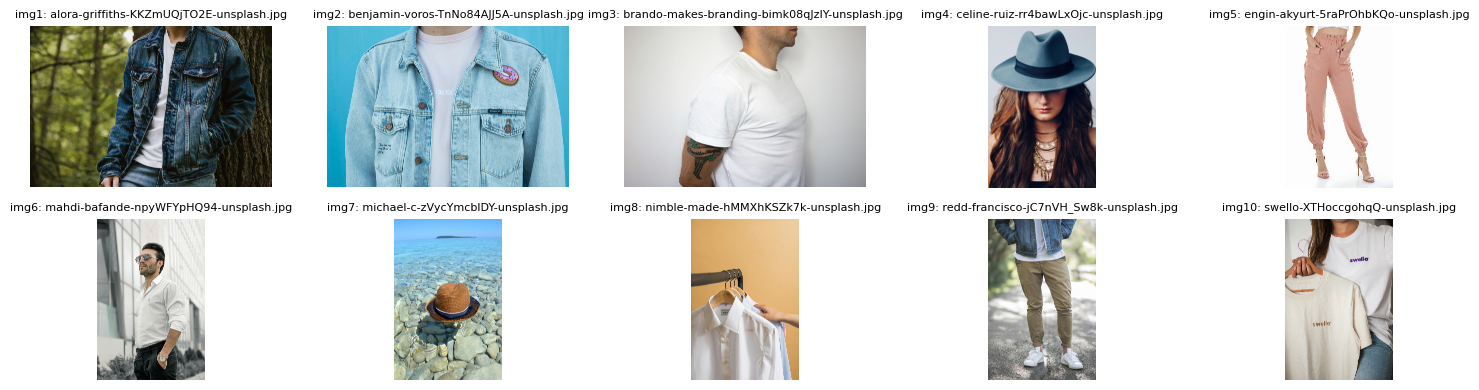

In [6]:
thumbs = [Image.open(p).convert("RGB") for p in imgs]
cols = 5; rows = (len(thumbs)+cols-1)//cols
plt.figure(figsize=(cols*3, rows*2))
for i, im in enumerate(thumbs, 1):
    ax = plt.subplot(rows, cols, i); ax.imshow(im); ax.axis("off")
    ax.set_title(f"img{i}: {imgs[i-1].name}", fontsize=8)
plt.tight_layout()
plt.show()

In [7]:
CATEGORIES = {
    "white_dress_shirt": [
        "a photo of a white dress shirt", "a white button-up shirt", "a white long-sleeve shirt"
    ],
    "hat": [
        "a photo of a baseball cap", "a photo of a hat", "a black cap"
    ],
    "denim_shirt": [
        "a photo of a denim shirt", "a blue denim shirt"
    ],
    "jeans": [
        "a photo of blue jeans", "a photo of denim pants"
    ],
    "white_tshirt": [
        "a photo of a white t-shirt", "a plain white tee"
    ],
    "pants" : [
        "a photo of a pants", 
    ]
}


# Ïã§Ïäµ
## Ïù¥ÎØ∏ÏßÄ‚ÜíÏπ¥ÌÖåÍ≥†Î¶¨ Îß§Ïπ≠ ÏΩîÎìú ÏÑ§Î™Ö (CLIP, ViT-B/32)

ÏïÑÎûò ÏΩîÎìúÎäî Ïù¥ÎØ∏ÏßÄ 10Ïû•Í≥º Ïπ¥ÌÖåÍ≥†Î¶¨Î≥Ñ ÌÖçÏä§Ìä∏ ÎèôÏùòÏñ¥Î•º CLIPÏùò Í≥µÌÜµ ÏûÑÎ≤†Îî© Í≥µÍ∞ÑÏúºÎ°ú Ìà¨ÏòÅÌïú Îí§,
Ïù¥ÎØ∏ÏßÄÎßàÎã§ Top-3 Ïπ¥ÌÖåÍ≥†Î¶¨Î•º ÏòàÏ∏°ÌïòÎäî ÌååÏù¥ÌîÑÎùºÏù∏

### Î™©Ï†Å

- Ïù¥ÎØ∏ÏßÄÏôÄ ÌÖçÏä§Ìä∏(Ïπ¥ÌÖåÍ≥†Î¶¨ ÏÑ§Î™Ö)Î•º Í∞ôÏùÄ Ï∞®Ïõê ùê∑ Ïùò ÏûÑÎ≤†Îî©ÏúºÎ°ú Î≥ÄÌôò
- ÏûÑÎ≤†Îî©ÏùÑ L2 Ï†ïÍ∑úÌôîÌïòÏó¨ ÎÇ¥Ï†Å = ÏΩîÏÇ¨Ïù∏ Ïú†ÏÇ¨ÎèÑ
- Ïπ¥ÌÖåÍ≥†Î¶¨ÎßàÎã§ Ïó¨Îü¨ ÌëúÌòÑ(ÎèôÏùòÏñ¥)ÏùÑ ÌèâÍ∑†Ìï¥ ÌîÑÎ°úÌÜ†ÌÉÄÏûÖ ÏûÑÎ≤†Îî© ÏÉùÏÑ±
- Í∞Å Ïù¥ÎØ∏ÏßÄÍ∞Ä Ïñ¥Îñ§ Ïπ¥ÌÖåÍ≥†Î¶¨Ïóê Í∞ÄÏû• Í∞ÄÍπåÏö¥ÏßÄ Top-K Îß§Ïπ≠ ÏÇ∞Ï∂ú

### ÏûÖÎ†•/Ï∂úÎ†• Í∞úÎÖê

#### ÏûÖÎ†•
- $\texttt{imgs}$: Ïù¥ÎØ∏ÏßÄ Í≤ΩÎ°ú Î¶¨Ïä§Ìä∏ $(N\ \text{Ïû•})$
- $\texttt{CATEGORIES}$: $\{\ \text{Ïπ¥ÌÖåÍ≥†Î¶¨Î™Ö} : [\text{ÎèôÏùòÏñ¥ Î¨∏Ïû•Îì§}]\ \}$ $(K\ \text{Í∞ú})$

#### Ï∂úÎ†• (Ï£ºÏöî Î≥ÄÏàò)
- $\mathbf{F}_{\text{img}} \in \mathbb{R}^{N \times D}$: Ïù¥ÎØ∏ÏßÄ ÏûÑÎ≤†Îî© *(Ï†ïÍ∑úÌôî)*
- $\mathbf{F}_{\text{txt}}^{\text{proto}} \in \mathbb{R}^{K \times D}$: Ïπ¥ÌÖåÍ≥†Î¶¨ **ÌîÑÎ°úÌÜ†ÌÉÄÏûÖ** ÏûÑÎ≤†Îî© *(Ï†ïÍ∑úÌôî)*
- $\mathbf{S}_{\text{ic}} = \mathbf{F}_{\text{img}}\ \mathbf{F}_{\text{txt}}^{\text{proto}\top} \in \mathbb{R}^{N \times K}$: Ïù¥ÎØ∏ÏßÄ‚ÄìÏπ¥ÌÖåÍ≥†Î¶¨ **ÏΩîÏÇ¨Ïù∏ Ïú†ÏÇ¨ÎèÑ** ÌñâÎ†¨
- $\texttt{mapping}$: Í∞Å Ïù¥ÎØ∏ÏßÄÏùò **Top-3 Ïπ¥ÌÖåÍ≥†Î¶¨**ÏôÄ Ïú†ÏÇ¨ÎèÑ Ï†êÏàò Î¶¨Ïä§Ìä∏

> Î≥¥ÌÜµ $D=512$. Ïòà: $N=10$, $K=5$ Ïù¥Î©¥  
> $\mathbf{F}_{\text{img}} \in \mathbb{R}^{10 \times 512}$, $\mathbf{F}_{\text{txt}}^{\text{proto}} \in \mathbb{R}^{5 \times 512}$, $\mathbf{S}_{\text{ic}} \in \mathbb{R}^{10 \times 5}$.


In [8]:
# === 3) ÏûÑÎ≤†Îî© ===
@torch.no_grad()
def get_image_features(paths):
    ims=[Image.open(p).convert("RGB") for p in paths]
    x=processor(images=ims, return_tensors="pt").to(device)
    f=model.get_image_features(**x); f=f/f.norm(dim=-1, keepdim=True)
    return f

@torch.no_grad()
def text_feats(texts):
    x=processor(text=texts, return_tensors="pt", padding=True, truncation=True).to(device)
    f=model.get_text_features(**x); f=f/f.norm(dim=-1, keepdim=True)
    return f

1. get_image_features(...)Î°ú Ïù¥ÎØ∏ÏßÄ ÏûÑÎ≤†Îî© $\mathbf{F}_{\text{img}} \in \mathbb{R}^{N\times D}$ Ï∂îÏ∂ú

2. text_feats(...)Î°ú ÌÖçÏä§Ìä∏ ÏûÑÎ≤†Îî©ÏùÑ ÎΩëÍ≥†, ÎèôÏùòÏñ¥ ÌèâÍ∑†ÏúºÎ°ú Ïπ¥ÌÖåÍ≥†Î¶¨ ÌîÑÎ°úÌÜ†ÌÉÄÏûÖ $\mathbf{F}_{\text{txt}}^{\text{proto}} \in \mathbb{R}^{K\times D} $ ÏÉùÏÑ±

3. Îëò Îã§ L2 Ï†ïÍ∑úÌôî ‚Üí ÎÇ¥Ï†ÅÏù¥ ÏΩîÏÇ¨Ïù∏ Ïú†ÏÇ¨ÎèÑÎûë Í∞ôÏïÑÏßê

4. Ïú†ÏÇ¨ÎèÑ ÌñâÎ†¨ $\mathbf{S}_{\text{ic}} = \mathbf{F}_{\text{img}}\ \mathbf{F}_{\text{txt}}^{\text{proto}\top} \in \mathbb{R}^{N\times K} $ Í≥ÑÏÇ∞

5. Í∞Å Ïù¥ÎØ∏ÏßÄÎ≥ÑÎ°ú Top-K Ïπ¥ÌÖåÍ≥†Î¶¨(Ïòà: Top-3) ÎΩëÏïÑÏÑú mappingÏóê Ï†ÄÏû•

In [9]:
F_img = get_image_features(imgs)

# Ïπ¥ÌÖåÍ≥†Î¶¨Î≥Ñ ÌÖçÏä§Ìä∏ ÌîÑÎ°úÌÜ†ÌÉÄÏûÖ(ÎèôÏùòÏñ¥ ÌèâÍ∑†)
cat_names = list(CATEGORIES.keys())
proto = []
for name in cat_names:
    F_t = text_feats(CATEGORIES[name])
    proto.append(F_t.mean(dim=0, keepdim=True))
F_txt_proto = torch.cat(proto, dim=0)              # [K, D]
F_txt_proto = F_txt_proto / F_txt_proto.norm(dim=-1, keepdim=True)

# === 4) Ïù¥ÎØ∏ÏßÄ‚ÜíÏπ¥ÌÖåÍ≥†Î¶¨ Îß§Ïπ≠ (Top-3) ===
S_ic = (F_img @ F_txt_proto.T).cpu().numpy()       # [N_img, K]
idx_top = np.argsort(-S_ic, axis=1)[:, :3]

mapping = []
for i in range(len(imgs)):
    top3 = [(cat_names[j], float(S_ic[i, j])) for j in idx_top[i]]
    mapping.append({
        "image_idx": i+1, "image_file": imgs[i].name,
        "pred1": top3[0][0], "score1": round(top3[0][1], 4),
        "pred2": top3[1][0], "score2": round(top3[1][1], 4),
        "pred3": top3[2][0], "score3": round(top3[2][1], 4),
    })

In [10]:
print("F_img:", F_img.shape, "F_txt_proto:", F_txt_proto.shape, "S_ic:", S_ic.shape)
for i in range(len(imgs)):
    j = S_ic[i].argmax()
    print(f"img{i+1} ({imgs[i].name}) ‚Üí {cat_names[j]}  score={S_ic[i,j]:.3f}")

F_img: torch.Size([10, 512]) F_txt_proto: torch.Size([6, 512]) S_ic: (10, 6)
img1 (alora-griffiths-KKZmUQjTO2E-unsplash.jpg) ‚Üí denim_shirt  score=0.297
img2 (benjamin-voros-TnNo84AJJ5A-unsplash.jpg) ‚Üí denim_shirt  score=0.296
img3 (brando-makes-branding-bimk08qJzIY-unsplash.jpg) ‚Üí white_tshirt  score=0.314
img4 (celine-ruiz-rr4bawLxOjc-unsplash.jpg) ‚Üí hat  score=0.249
img5 (engin-akyurt-5raPrOhbKQo-unsplash.jpg) ‚Üí pants  score=0.258
img6 (mahdi-bafande-npyWFYpHQ94-unsplash.jpg) ‚Üí white_dress_shirt  score=0.301
img7 (michael-c-zVycYmcblDY-unsplash.jpg) ‚Üí hat  score=0.275
img8 (nimble-made-hMMXhKSZk7k-unsplash.jpg) ‚Üí white_dress_shirt  score=0.301
img9 (redd-francisco-jC7nVH_Sw8k-unsplash.jpg) ‚Üí pants  score=0.282
img10 (swello-XTHoccgohqQ-unsplash.jpg) ‚Üí white_tshirt  score=0.266


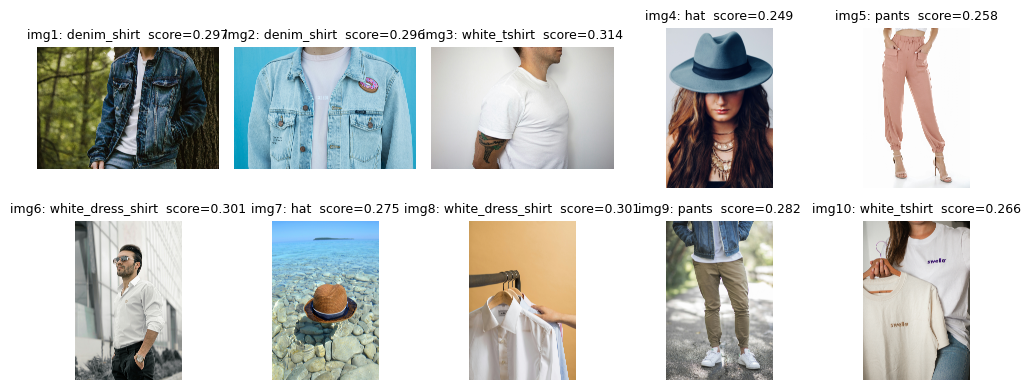

In [11]:
# top-1 Ïπ¥ÌÖåÍ≥†Î¶¨ÏôÄ Ï†êÏàò Ìïú Î≤àÏóê Íµ¨ÌïòÍ∏∞
pred_top1 = S_ic.argmax(axis=1)   # shape: (N,)
score_top1 = S_ic.max(axis=1)     # shape: (N,)

cols = 5
rows = (len(thumbs) + cols - 1) // cols
plt.figure(figsize=(cols*2, rows*2))

for i, (im, pred, sc) in enumerate(zip(thumbs, pred_top1, score_top1), start=1):
    ax = plt.subplot(rows, cols, i)
    ax.imshow(im); ax.axis("off")
    ax.set_title(f"img{i}: {cat_names[int(pred)]}  score={float(sc):.3f}", fontsize=9)

plt.tight_layout()
plt.savefig(OUT / "thumbs_pred_top1.png", dpi=160)
plt.show()


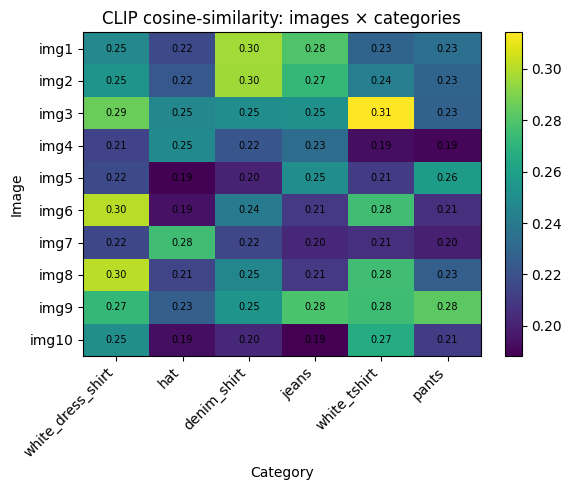

In [12]:
fig = plt.figure(figsize=(max(6, 0.9*len(cat_names)), max(4, 0.5*len(imgs))))
ax = plt.gca()
im = ax.imshow(S_ic, aspect="auto")
plt.title("CLIP cosine-similarity: images √ó categories")
plt.xlabel("Category"); plt.ylabel("Image")
plt.colorbar(im)

plt.xticks(range(len(cat_names)), cat_names, rotation=45, ha="right")
plt.yticks(range(len(imgs)), [f"img{i+1}" for i in range(len(imgs))])

# Í∞í Ïò§Î≤ÑÎ†àÏù¥ (ÏûëÏùÑ ÎïåÎßå)
if S_ic.size <= 200:
    for i in range(S_ic.shape[0]):
        for j in range(S_ic.shape[1]):
            ax.text(j, i, f"{S_ic[i,j]:.2f}", ha="center", va="center", fontsize=7)

plt.tight_layout()
plt.savefig(OUT / "clip_heatmap_ic_annot.png", dpi=160)
plt.show()


### ÏùòÎ¨∏Ï†ê : ÌÖçÏä§Ìä∏ ÏûÑÎ≤†Îî©, Ïù¥ÎØ∏ÏßÄ ÏûÑÎ≤†Îî© Í∞ÅÍ∞Å Ï∂îÏ∂úÌï¥ÏÑú dot-product Î°ú Í≥ÑÏÇ∞Ìï¥Ïïº ÎêòÎäîÍ±¥Í∞Ä

[Ï∞æÏïÑÎ≥∏ Í≤∞Í≥º]

CLIPÏùÄ Ïù¥ÎØ∏ÏßÄÏôÄ ÌÖçÏä§Ìä∏Î•º ÎèôÏãúÏóê ÎÑ£ÏúºÎ©¥ ÎÇ¥Î∂ÄÏóêÏÑú Ï†ïÍ∑úÌôîÎêú ÏûÑÎ≤†Îî©Ïùò ÎÇ¥Ï†ÅÏóê **learned temperature(= logit_scale)**Î•º Í≥±Ìï¥ **Ïú†ÏÇ¨ÎèÑ(logits)**Î•º Î∞îÎ°ú Î∞òÌôò
- Í∑∏Î†áÏßÄÎßå Ïã§Î¨¥/ÌîÑÎ°úÏ†ùÌä∏ÏóêÏÑúÎäî ‚ÄúÍ∞ÅÏûê ÏûÑÎ≤†Îî© ‚Üí dot-product‚Äù Î∞©ÏãùÏù¥ Ï†ïÏÑù
1. Ï∫êÏã±/Ïû¨ÏÇ¨Ïö©: Ïπ¥ÌÉàÎ°úÍ∑∏(ÏàòÏ≤ú~ÏàòÎ∞±Îßå Ïù¥ÎØ∏ÏßÄ) ÏûÑÎ≤†Îî©ÏùÄ ÎØ∏Î¶¨ ÎΩëÏïÑ Ï†ÄÏû•, ÏßàÏùò ÌÖçÏä§Ìä∏Îßå ÏûÑÎ≤†Îî©Ìï¥ÏÑú Îπ†Î•¥Í≤å Í≤ÄÏÉâ.

2. ÌôïÏû•ÏÑ±: ÎåÄÎüâ Í≤ÄÏÉâÏùÄ ÌñâÎ†¨ Í≥±/ANN(FAISS, ScaNN)Î°ú Ïä§ÏºÄÏùºÏïÑÏõÉ.

3. Ïú†Ïó∞ÏÑ±: temperature Ï°∞Ï†à, ÏûÑÍ≥ÑÍ∞í, re-ranking, ÌîÑÎ°úÌÜ†ÌÉÄÏûÖ ÌèâÍ∑†(ÎèôÏùòÏñ¥ ÌèâÍ∑†) Í∞ôÏùÄ Ïª§Ïä§ÌÖÄ Î°úÏßÅ Ï†ÅÏö©Ïù¥ Ïâ¨ÏõÄ.

4. ÎπÑÎèôÍ∏∞ ÌååÏù¥ÌîÑÎùºÏù∏: Ïù¥ÎØ∏ÏßÄ Ï™Ω/ÌÖçÏä§Ìä∏ Ï™ΩÏùÑ Î∂ÑÎ¶¨ Ïö¥ÏòÅ Í∞ÄÎä•(ÏÑúÎπÑÏä§ Íµ¨Ï°∞Ïóê Ïú†Î¶¨).

ÏÑ§Í≥ÑÏ†ÅÏúºÎ°ú CLIPÏùÄ ‚ÄòÎëê ÌÉÄÏõå(two-tower)‚Äô Íµ¨Ï°∞ÎùºÏÑú, Î™®Îã¨Î¶¨Ìã∞ Í∞Ñ ÍµêÏ∞® Ï£ºÏùò(cross-attention) ÏóÜÏù¥ Í≥µÌÜµ Í≥µÍ∞ÑÏóêÏÑúÏùò ÏΩîÏÇ¨Ïù∏ Ïú†ÏÇ¨ÎèÑÍ∞Ä ÏµúÏ¢Ö Ï†êÏàò
Ï¶â, ‚ÄúÏûÑÎ≤†Îî© ‚Üí ÎÇ¥Ï†Å‚ÄùÏù¥ Î™®Îç∏ ÏÑ§Í≥Ñ ÏûêÏ≤¥Ïùò ÌïµÏã¨Ïù¥ÏóêÏöî. Ïö∞Î¶¨Í∞Ä Î∞îÍπ•ÏóêÏÑú dot-productÎ•º ÌïòÎäî Í≤å ÌõàÎ†® Ïãú Ï†êÏàò Í≥ÑÏÇ∞Í≥º ÎèôÏùºÌïú ÏõêÎ¶¨